In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-airline-sentiment/database.sqlite
/kaggle/input/twitter-airline-sentiment/Tweets.csv
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from sklearn.model_selection import train_test_split
from sklearn import metrics
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Embedding,Bidirectional,Dense,Conv1D,Flatten,LSTM,GlobalMaxPooling1D,Dropout

Using TensorFlow backend.


In [3]:
tweets = pd.read_csv('/kaggle/input/twitter-airline-sentiment/Tweets.csv')

In [4]:
tweets.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
train=tweets.loc[:,["airline_sentiment","text"]]
train_k=tweets.loc[:,["airline_sentiment","text"]]

In [6]:
train.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


['neutral', 'negative', 'positive']


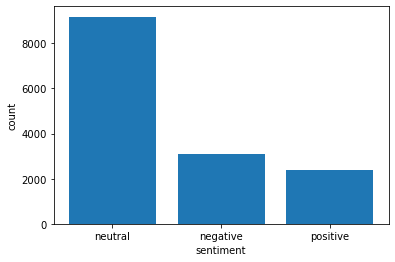

In [7]:
x_axis= list((set(train["airline_sentiment"])))
print(x_axis)
y_axis = train.groupby("airline_sentiment").count()
plt.bar(x_axis,y_axis["text"])
plt.ylabel("count")
plt.xlabel("sentiment")
plt.show()

In [8]:
from sklearn.preprocessing import LabelEncoder  
le = LabelEncoder() 
y= le.fit_transform(train['airline_sentiment']) 
from keras.utils import to_categorical
Y = to_categorical(y)

In [9]:
print(Y.shape)
print(Y)


(14640, 3)
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [10]:
for i in range(0,len(train["text"])):
    words = word_tokenize(train["text"][i])
    words = [word for word in words if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    porter = PorterStemmer()
    stemmed_words= [ porter.stem(word) for word in words]
    train["text"][i]=stemmed_words

In [11]:
train["text"][1]

['virginamerica', 'plu', 'ad', 'commerci', 'experi', 'tacki']

In [12]:
#making dictionary
dictionary = [word  for subli in train["text"] for word in subli ]

In [13]:
dictionary = list(set(dictionary))
dictionary = sorted(dictionary)

In [14]:
print(dictionary)

['A', 'AA', 'AB', 'AC', 'AF', 'AH', 'AL', 'AM', 'AN', 'AP', 'AT', 'AV', 'AZ', 'Aa', 'Ah', 'Am', 'An', 'Ap', 'As', 'At', 'Aw', 'Az', 'B', 'BA', 'BC', 'BE', 'BF', 'BS', 'BY', 'Bc', 'Be', 'By', 'C', 'CA', 'CB', 'CC', 'CO', 'CP', 'CR', 'CS', 'CT', 'CX', 'Ca', 'Cc', 'Cs', 'Ct', 'D', 'DC', 'DJ', 'DL', 'DM', 'DO', 'DR', 'Da', 'De', 'Dm', 'Do', 'Dr', 'E', 'EB', 'EP', 'ET', 'EU', 'Eh', 'El', 'En', 'F', 'FA', 'FB', 'FC', 'FF', 'FL', 'FO', 'FU', 'Fe', 'Fl', 'Ft', 'G', 'GA', 'GD', 'GF', 'GO', 'Gf', 'Go', 'Gs', 'H', 'HA', 'HD', 'HE', 'HI', 'HN', 'HP', 'HR', 'HS', 'He', 'Hi', 'Hm', 'Hv', 'I', 'ID', 'IF', 'IL', 'IM', 'IN', 'IS', 'IT', 'Id', 'If', 'Im', 'In', 'Is', 'It', 'J', 'JB', 'JH', 'JJ', 'JP', 'JS', 'JT', 'K', 'KC', 'KN', 'KP', 'Ky', 'L', 'LA', 'LB', 'LH', 'La', 'M', 'MC', 'ME', 'MI', 'MP', 'MR', 'MS', 'MT', 'MV', 'MY', 'Me', 'Mr', 'Mt', 'My', 'N', 'NA', 'NC', 'NE', 'NH', 'NJ', 'NL', 'NM', 'NO', 'NY', 'Nj', 'No', 'O', 'OC', 'OF', 'OH', 'OK', 'ON', 'OR', 'OS', 'OW', 'Of', 'Oh', 'Ok', 'On', 'Or', 

In [15]:
tokenizer = Tokenizer(num_words = 4000)
tokenizer.fit_on_texts(train_k["text"])
sequence = tokenizer.texts_to_sequences(train_k["text"])

In [16]:
max_seq_len = 1000
padded_seq = pad_sequences(sequence , maxlen = max_seq_len )

In [17]:
padded_seq

array([[   0,    0,    0, ...,   81,   62,  226],
       [   0,    0,    0, ...,    1,    2,  201],
       [   0,    0,    0, ...,  156,  150,  193],
       ...,
       [   0,    0,    0, ...,  456,  256,    1],
       [   0,    0,    0, ...,  131,   11, 2696],
       [   0,    0,    0, ...,    2,  179,    8]], dtype=int32)

In [18]:
X_train,X_test,Y_train,Y_test = train_test_split(padded_seq,Y ,train_size = 0.80,random_state= 37)

In [19]:
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)



11712
11712
2928
2928
(11712, 1000)
(11712, 3)
(2928, 1000)
(2928, 3)


In [20]:
index_of_words = tokenizer.word_index
print(len(index_of_words))

15768


In [21]:
f = open('/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt')
embedd_index = {}
for line in f:
    val = line.split()
    word = val[0]
    coff = np.asarray(val[1:],dtype = 'float')
    embedd_index[word] = coff

f.close()
print('Found %s word vectors.' % len(embedd_index))

Found 400000 word vectors.


In [22]:
embed_num_dims = 100

In [23]:
embedd_index['good']

array([-0.030769 ,  0.11993  ,  0.53909  , -0.43696  , -0.73937  ,
       -0.15345  ,  0.081126 , -0.38559  , -0.68797  , -0.41632  ,
       -0.13183  , -0.24922  ,  0.441    ,  0.085919 ,  0.20871  ,
       -0.063582 ,  0.062228 , -0.051234 , -0.13398  ,  1.1418   ,
        0.036526 ,  0.49029  , -0.24567  , -0.412    ,  0.12349  ,
        0.41336  , -0.48397  , -0.54243  , -0.27787  , -0.26015  ,
       -0.38485  ,  0.78656  ,  0.1023   , -0.20712  ,  0.40751  ,
        0.32026  , -0.51052  ,  0.48362  , -0.0099498, -0.38685  ,
        0.034975 , -0.167    ,  0.4237   , -0.54164  , -0.30323  ,
       -0.36983  ,  0.082836 , -0.52538  , -0.064531 , -1.398    ,
       -0.14873  , -0.35327  , -0.1118   ,  1.0912   ,  0.095864 ,
       -2.8129   ,  0.45238  ,  0.46213  ,  1.6012   , -0.20837  ,
       -0.27377  ,  0.71197  , -1.0754   , -0.046974 ,  0.67479  ,
       -0.065839 ,  0.75824  ,  0.39405  ,  0.15507  , -0.64719  ,
        0.32796  , -0.031748 ,  0.52899  , -0.43886  ,  0.6740

In [24]:
embedding_matrix = np.zeros((len(index_of_words) + 1, embed_num_dims))

tokens = []
labels = []

for word,i in index_of_words.items():
    temp = embedd_index.get(word)
    if temp is not None:
        embedding_matrix[i] = temp
        
#for plotting
        tokens.append(embedding_matrix[i])
        labels.append(word)

In [25]:
embedding_matrix.shape

(15769, 100)

(200, 2)


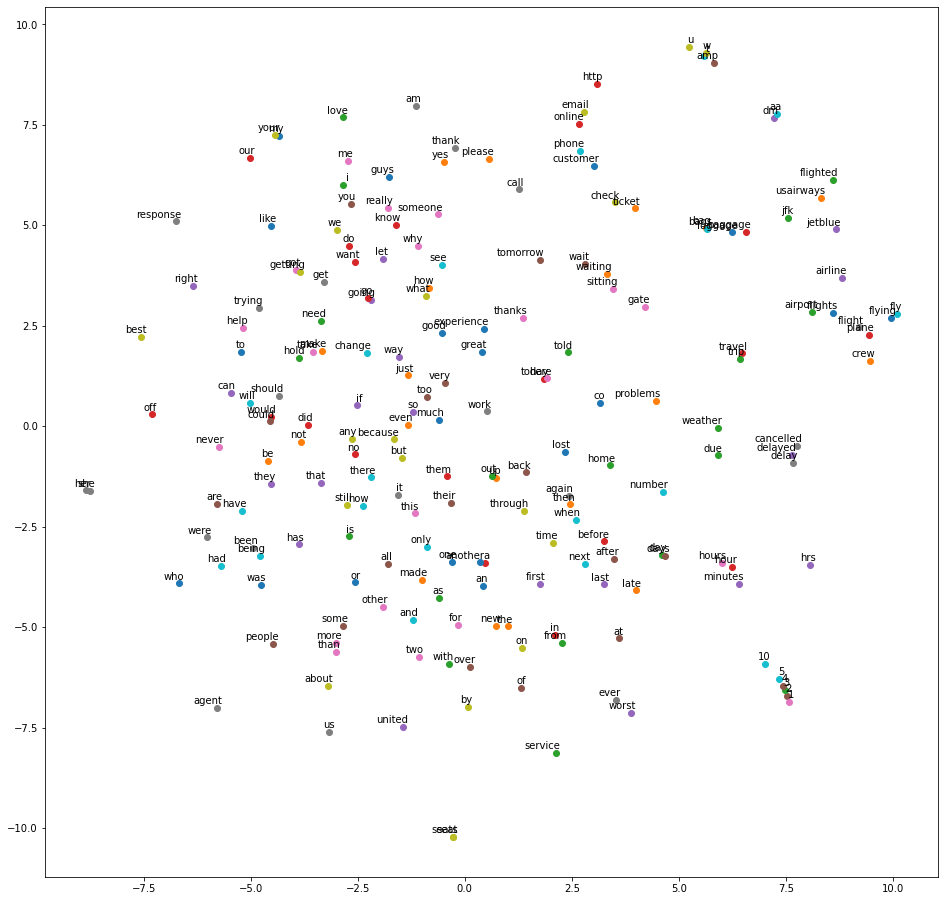

In [26]:
from sklearn.manifold import TSNE
#TSNE algorithm used to visualize word embeddings having huge amount (100) dimensions

def tsne():
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens[:200])
    print(new_values.shape)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16,16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

    
    
    
    
tsne()

In [27]:
#Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(len(index_of_words) + 1 , embed_num_dims , input_length = max_seq_len , weights = [embedding_matrix])

In [28]:
model = Sequential()
model.add(embedd_layer)
model.add(Bidirectional(LSTM(45 , return_sequences = True , dropout = 0.1 , recurrent_dropout = 0.1)))
model.add(GlobalMaxPooling1D())
model.add(Dense(6,activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(3,activation = 'sigmoid'))

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         1576900   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 90)          52560     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 90)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 546       
_________________________________________________________________
dropout_1 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 21        
Total params: 1,630,027
Trainable params: 1,630,027
Non-trainable params: 0
____________________________________________

In [30]:
from keras.optimizers import Adam
add = Adam(learning_rate=0.001,
    beta_1=0.99,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,)
model.compile(loss = 'categorical_crossentropy' , optimizer = add , metrics = ['accuracy'])


In [31]:
hist = model.fit(X_train,Y_train,epochs = 30, batch_size = 500, validation_data = (X_test,Y_test))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11712 samples, validate on 2928 samples
Epoch 1/30
11712/11712 [==============================] - 109s 9ms/step - loss: 0.9526 - accuracy: 0.5711 - val_loss: 0.8776 - val_accuracy: 0.6359
Epoch 2/30
11712/11712 [==============================] - 110s 9ms/step - loss: 0.8978 - accuracy: 0.6247 - val_loss: 0.8629 - val_accuracy: 0.6363
Epoch 3/30
11712/11712 [==============================] - 108s 9ms/step - loss: 0.8775 - accuracy: 0.6254 - val_loss: 0.8383 - val_accuracy: 0.6359
Epoch 4/30
11712/11712 [==============================] - 109s 9ms/step - loss: 0.8437 - accuracy: 0.6258 - val_loss: 0.8003 - val_accuracy: 0.6359
Epoch 5/30
11712/11712 [==============================] - 109s 9ms/step - loss: 0.8140 - accuracy: 0.6263 - val_loss: 0.7730 - val_accuracy: 0.6359
Epoch 6/30
11712/11712 [==============================] - 106s 9ms/step - loss: 0.7877 - accuracy: 0.6276 - val_loss: 0.7337 - val_accuracy: 0.6400
Epoch 7/30
11712/11712 [==============================] - 110s 